# Download MNIST Data from Website

In [1]:
%%time
import pickle, gzip, urllib.request, json
import numpy as np

CPU times: user 262 ms, sys: 393 ms, total: 655 ms
Wall time: 223 ms


In [42]:
%%time

# Load the dataset
urllib.request.urlretrieve("http://deeplearning.net/data/mnist/mnist.pkl.gz", "mnist.pkl.gz")
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
print(train_set[0].shape)

(50000, 784)
CPU times: user 2.51 s, sys: 888 ms, total: 3.4 s
Wall time: 8.05 s


In [71]:
!mv mnist.pkl.gz ../data/raw/

# Explore Dataset- View 10 first images

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

This is a 5


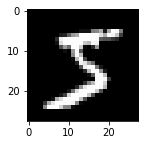

This is a 0


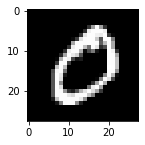

This is a 4


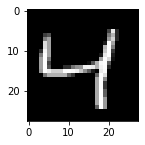

This is a 1


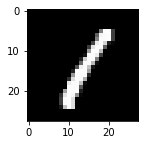

This is a 9


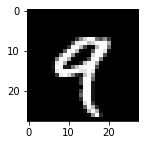

This is a 2


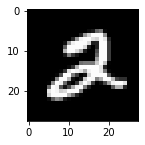

This is a 1


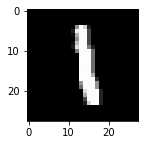

This is a 3


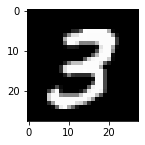

This is a 1


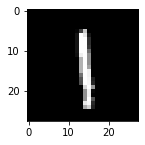

This is a 4


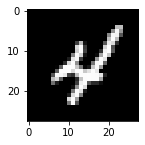

In [44]:
plt.rcParams["figure.figsize"] = (2,10)


for i in range(0, 10):
    img = train_set[0][i]
    label = train_set[1][i]
    img_reshape = img.reshape((28,28))
    imgplot = plt.imshow(img_reshape, cmap='gray')
    print('This is a {}'.format(label))
    plt.show()

# Check AWS CLI Login

In [3]:
!aws configure list

      Name                    Value             Type    Location
      ----                    -----             ----    --------
   profile                <not set>             None    None
access_key     ****************3DHR shared-credentials-file    
secret_key     ****************iVYX shared-credentials-file    
    region                us-west-2      config-file    ~/.aws/config


# Create S3 Bucket 

In [4]:
!aws s3 ls

2020-09-08 16:38:43 sagemaker-mnistml-learningtutorial


In [5]:
!aws s3 mb s3://sagemaker-mnistml-learningtutorial2

make_bucket: sagemaker-mnistml-learningtutorial2


In [5]:
!aws s3 ls 

2020-09-08 16:38:43 sagemaker-mnistml-learningtutorial
2020-09-11 17:07:08 sagemaker-mnistml-learningtutorial2


# Convert to CSV and save to S3 bucket
## Bucket: sagemaker-mnistml-learningtutorial2

In [6]:
%%time


import os
import boto3
import re
import copy
import time
import io
import struct
from time import gmtime, strftime

CPU times: user 892 ms, sys: 0 ns, total: 892 ms
Wall time: 939 ms


In [5]:
%%time
region = boto3.Session().region_name


bucket='sagemaker-mnistml-learningtutorial2' # Replace with your s3 bucket name
prefix = 'sagemaker/xgboost-mnist' # Used as part of the path in the bucket where you store data


def convert_data():
    data_partitions = [('train', train_set), ('validation', valid_set), ('test', test_set)]
    for data_partition_name, data_partition in data_partitions:
        print('{}: {} {}'.format(data_partition_name, data_partition[0].shape, data_partition[1].shape))
        print ("making labels")
        labels = [t.tolist() for t in data_partition[1]]
        print ("labels completed")
        print ("making features")
        features = [t.tolist() for t in data_partition[0]]
        print ("features completed")
        print ("doing np.insert")
        if data_partition_name != 'test':
            examples = np.insert(features, 0, labels, axis=1)
        else:
            examples = features
        #print(examples[50000,:])
        print ("np.insert completed")
        print ("writing data.csv")
        np.savetxt('data.csv', examples, delimiter=',')
        
        
        print ("uploading to S3")
        key = "{}/{}/examples".format(prefix,data_partition_name)
        url = 's3://{}/{}'.format(bucket, key)
        boto3.Session().resource('s3').Bucket(bucket).Object(key).upload_file('data.csv')
        print('Done writing to {}'.format(url))
        
convert_data()

train: (50000, 784) (50000,)
making labels
labels completed
making features
features completed
doing np.insert
np.insert completed
writing data.csv
uploading to S3
Done writing to s3://sagemaker-mnistml-learningtutorial2/sagemaker/xgboost-mnist/train/examples
validation: (10000, 784) (10000,)
making labels
labels completed
making features
features completed
doing np.insert
np.insert completed
writing data.csv
uploading to S3
Done writing to s3://sagemaker-mnistml-learningtutorial2/sagemaker/xgboost-mnist/validation/examples
test: (10000, 784) (10000,)
making labels
labels completed
making features
features completed
doing np.insert
np.insert completed
writing data.csv
uploading to S3
Done writing to s3://sagemaker-mnistml-learningtutorial2/sagemaker/xgboost-mnist/test/examples
CPU times: user 6min 51s, sys: 2min 20s, total: 9min 11s
Wall time: 48min 21s


# Import Sagemaker and set Role for AWS CLI

In [ ]:
import sagemaker

In [76]:
rolenameinAWS=input("What is the rolename you created with the policy 'AmazonSagemakerFullAccess'? ")

What is the rolename you created with the policy 'AmazonSagemakerFullAccess'? Sagemaker_dev


In [43]:
iam = boto3.client('iam') 
role = iam.get_role(RoleName=rolenameinAWS)['Role']['Arn']

# Create and Run a Training Job 
## Create Training Job and Deploy model using Python-SDK


In [45]:
container = sagemaker.image_uris.retrieve("xgboost",boto3.Session().region_name, "latest")

bucket='sagemaker-mnistml-learningtutorial2' # Replace with your s3 bucket name
prefix = 'sagemaker/xgboost-mnist'

In [46]:
train_data = 's3://{}/{}/{}'.format(bucket, prefix, 'train')

validation_data = 's3://{}/{}/{}'.format(bucket, prefix, 'validation')

s3_output_location = 's3://{}/{}/{}'.format(bucket, prefix, 'xgboost_model_sdk')
print(train_data)

s3://sagemaker-mnistml-learningtutorial2/sagemaker/xgboost-mnist/train


In [47]:
#create sagemaker.estimator.Estimator class 
xgb_model = sagemaker.estimator.Estimator(container,
                                         role, 
                                         instance_count=1, 
                                         instance_type='ml.m4.xlarge',
                                         volume_size = 5,
                                         output_path=s3_output_location,
                                         sagemaker_session=sagemaker.Session())

In [48]:
# Set Hyperparameters
xgb_model.set_hyperparameters(max_depth = 5,
                              eta = .2,
                              gamma = 4,
                              min_child_weight = 6,
                              silent = 0,
                              objective = "multi:softmax",
                              num_class = 10,
                              num_round = 10)

In [49]:
# use train and validation for training job 
train_channel = sagemaker.inputs.TrainingInput(train_data, content_type='text/csv')
valid_channel = sagemaker.inputs.TrainingInput(validation_data, content_type='text/csv')

data_channels = {'train': train_channel, 'validation': valid_channel}

In [50]:
# Start model training
xgb_model.fit(inputs=data_channels,  logs=True)

2020-09-12 03:28:52 Starting - Starting the training job...
2020-09-12 03:28:54 Starting - Launching requested ML instances......
2020-09-12 03:30:02 Starting - Preparing the instances for training...
2020-09-12 03:30:55 Downloading - Downloading input data......
2020-09-12 03:31:51 Training - Downloading the training image...
2020-09-12 03:32:11 Training - Training image download completed. Training in progress.Arguments: train
[2020-09-12:03:32:12:INFO] Running standalone xgboost training.
[2020-09-12:03:32:12:INFO] File size need to be processed in the node: 1122.95mb. Available memory size in the node: 8494.5mb
[2020-09-12:03:32:12:INFO] Determined delimiter of CSV input is ','
[03:32:12] S3DistributionType set as FullyReplicated
[03:32:19] 50000x784 matrix with 39200000 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2020-09-12:03:32:19:INFO] Determined delimiter of CSV input is ','
[03:32:19] S3DistributionType set as FullyReplicated
[03:32:20]

[03:33:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 4 pruned nodes, max_depth=5
[03:33:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 16 pruned nodes, max_depth=5
[03:33:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 2 pruned nodes, max_depth=5
[03:33:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 12 pruned nodes, max_depth=5
[6]#011train-merror:0.08064#011validation-merror:0.0864
[03:33:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 8 pruned nodes, max_depth=5
[03:33:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 14 pruned nodes, max_depth=5
[03:33:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 4 pruned nodes, max_depth=5
[03:33:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 2 pruned nodes, max_depth=5
[03:33:10] src/tree/updater_prune.cc:74: tree

In [54]:
from sagemaker.deserializers import JSONDeserializer
from sagemaker.serializers import CSVSerializer



In [55]:
# Deploy Model 
# Specify # of Instances

xgb_predictor = xgb_model.deploy(initial_instance_count=1,
                                instance_type='ml.t2.medium',
                                serializer=CSVSerializer(),
                                deserializer=JSONDeserializer()
                                )

# ?xgb_model.deploy

-------------!

In [40]:
# ?sagemaker.estimator.Estimator.deploy
#returns a sagemaker predictor object 

In [56]:
# ?sagemaker.Predictor

In [73]:
# Validate Model 

s3 = boto3.resource('s3')

test_key = "{}/test/examples".format(prefix)

s3.Bucket(bucket).download_file(test_key, 'test_data')

This is a 7


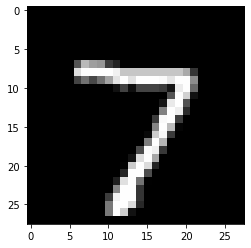

This is a 2


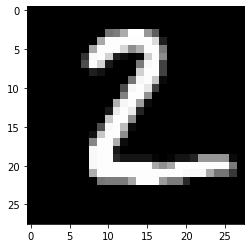

This is a 1


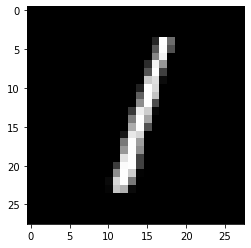

This is a 0


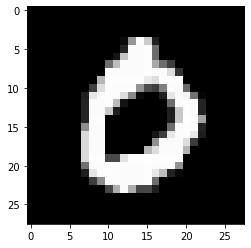

This is a 4


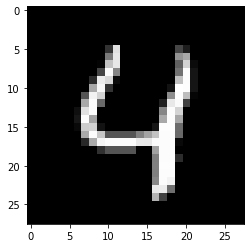

This is a 1


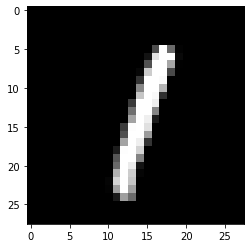

This is a 4


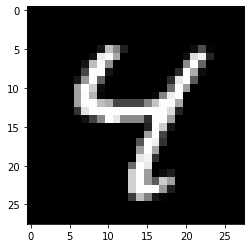

This is a 9


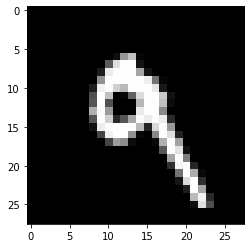

This is a 5


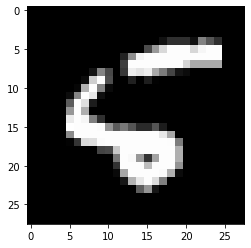

This is a 9


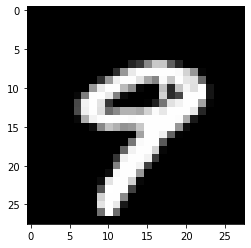

In [45]:
%matplotlib inline
                        
for i in range (0, 10):
    img = test_set[0][i]
    label = test_set[1][i]
    img_reshape = img.reshape((28,28))
    imgplot = plt.imshow(img_reshape, cmap='gray')
    print('This is a {}'.format(label))
    plt.show()

In [58]:
with open('test_data', 'r') as f:
    for j in range(0,10):
        single_test = f.readline()
        #print (single_test)
        result = xgb_predictor.predict(single_test)
        print(result)

7.0
2.0
1.0
0.0
4.0
1.0
4.0
9.0
5.0
9.0


# Create and Run a Training Job 
## Create Job using AWS SDK for Python (Boto3)

### To train a model, SageMaker uses the CreateTrainingJob API. The AWS SDK for Python (Boto3) provides the corresponding create_training_job method.

### When using this method, you provide the following information:

- The training algorithm – Specify the registry path of the Docker image that contains the training code. For the registry paths for the algorithms provided by SageMaker, see Common parameters for built-in algorithms.

- Algorithm-specific hyperparameters – Specify algorithm-specific hyperparameters to influence the final quality of the model. For information, see XGBoost Hyperparameters.

- The input and output configuration – Provide the S3 bucket where training data is stored and where SageMaker saves the results of model training (the model artifacts).

## Validate Model 

In [21]:
#Using xgboost Container
import sagemaker

container = sagemaker.image_uris.retrieve("xgboost",boto3.Session().region_name, "latest")

bucket='sagemaker-mnistml-learningtutorial2' # Replace with your s3 bucket name
prefix = 'sagemaker/xgboost-mnist'

In [22]:
bucket_path= "https://s3.us-west-2.amazonaws.com/"+bucket

In [23]:
#Ensure that the train and validation data folders generated above are reflected in the "InputDataConfig" parameter below.
common_training_params = \
{
    "AlgorithmSpecification": {
        "TrainingImage": container,
        "TrainingInputMode": "File"
    },
    "RoleArn": role,
    "OutputDataConfig": {
        "S3OutputPath": bucket_path + "/"+ prefix + "/xgboost"
    },
    "ResourceConfig": {
        "InstanceCount": 1,   
        "InstanceType": "ml.m4.xlarge",
        "VolumeSizeInGB": 5
    },
    "HyperParameters": {
        "max_depth":"5",
        "eta":"0.2",
        "gamma":"4",
        "min_child_weight":"6",
        "silent":"0",
        "objective": "multi:softmax",
        "num_class": "10",
        "num_round": "10"
    },
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 86400
    },
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": bucket_path + "/"+ prefix+ '/train/',
                    "S3DataDistributionType": "FullyReplicated" 
                }
            },
            "ContentType": "text/csv",
            "CompressionType": "None"
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": bucket_path + "/"+ prefix+ '/validation/',
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "text/csv",
            "CompressionType": "None"
        }
    ]
}

In [24]:
#training job params
training_job_name = 'xgboost-mnist' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print("Job name is:", training_job_name)

training_job_params = copy.deepcopy(common_training_params)
training_job_params['TrainingJobName'] = training_job_name
training_job_params['ResourceConfig']['InstanceCount'] = 1

Job name is: xgboost-mnist2020-09-12-02-51-10


In [25]:
#training job 
#%%time

region = boto3.Session().region_name
sm = boto3.Session().client('sagemaker')

sm.create_training_job(**training_job_params)


status = sm.describe_training_job(TrainingJobName=training_job_name)['TrainingJobStatus']
print(status)
sm.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=training_job_name)
status = sm.describe_training_job(TrainingJobName=training_job_name)['TrainingJobStatus']
print("Training job ended with status: " + status)
if status == 'Failed':
    message = sm.describe_training_job(TrainingJobName=training_job_name)['FailureReason']
    print('Training failed with the following error: {}'.format(message))
    raise Exception('Training job failed')

InProgress
Training job ended with status: Completed


In [26]:
model_name = training_job_name + '-mod'

info = sm.describe_training_job(TrainingJobName=training_job_name)
model_data = info['ModelArtifacts']['S3ModelArtifacts']
print(model_data)

primary_container = {
    'Image': container,
    'ModelDataUrl': model_data
}

create_model_response = sm.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

print(create_model_response['ModelArn'])

https://s3.us-west-2.amazonaws.com/sagemaker-mnistml-learningtutorial2/sagemaker/xgboost-mnist/xgboost/xgboost-mnist2020-09-12-02-51-10/output/model.tar.gz
arn:aws:sagemaker:us-west-2:821133245089:model/xgboost-mnist2020-09-12-02-51-10-mod


In [27]:
endpoint_config_name = 'DEMO-XGBoostEndpointConfig-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_config_name)
create_endpoint_config_response = sm.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType':'ml.m4.xlarge',
        'InitialVariantWeight':1,
        'InitialInstanceCount':1,
        'ModelName':model_name,
        'VariantName':'AllTraffic'}])

print("Endpoint Config Arn: " + create_endpoint_config_response['EndpointConfigArn'])

DEMO-XGBoostEndpointConfig-2020-09-12-02-58-16
Endpoint Config Arn: arn:aws:sagemaker:us-west-2:821133245089:endpoint-config/demo-xgboostendpointconfig-2020-09-12-02-58-16


In [32]:
# Create Endpoint
import time
#%%time

endpoint_name = 'DEMO-XGBoostEndpoint-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_name)
create_endpoint_response = sm.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_name)
print(create_endpoint_response['EndpointArn'])

resp = sm.describe_endpoint(EndpointName=endpoint_name)
status = resp['EndpointStatus']
print("Status: " + status)

while status=='Creating':
    time.sleep(60)
    resp = sm.describe_endpoint(EndpointName=endpoint_name)
    status = resp['EndpointStatus']
    print("Status: " + status)

print("Arn: " + resp['EndpointArn'])
print("Status: " + status)

DEMO-XGBoostEndpoint-2020-09-12-02-59-27
arn:aws:sagemaker:us-west-2:821133245089:endpoint/demo-xgboostendpoint-2020-09-12-02-59-27
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: InService
Arn: arn:aws:sagemaker:us-west-2:821133245089:endpoint/demo-xgboostendpoint-2020-09-12-02-59-27
Status: InService


In [33]:
# Get Test data
s3 = boto3.resource('s3')

test_key = "{}/test/examples".format(prefix)

s3.Bucket(bucket).download_file(test_key, 'test_data')

In [29]:
%matplotlib inline
                        
for i in range (0, 10):
    img = test_set[0][i]
    label = test_set[1][i]
    img_reshape = img.reshape((28,28))
    imgplot = plt.imshow(img_reshape, cmap='gray')
    print('This is a {}'.format(label))
    plt.show()

NameError: name 'test_set' is not defined

In [34]:
runtime_client = boto3.client('runtime.sagemaker')

In [35]:
with open('test_data', 'r') as f:
    
    for i in range(0,10):
        single_test = f.readline()
        response = runtime_client.invoke_endpoint(EndpointName = endpoint_name,
                                         ContentType = 'text/csv',
                                         Body = single_test)
        result = response['Body'].read().decode('ascii')
        print('Predicted label is {}.'.format(result))

Predicted label is 7.0.
Predicted label is 2.0.
Predicted label is 1.0.
Predicted label is 0.0.
Predicted label is 4.0.
Predicted label is 1.0.
Predicted label is 4.0.
Predicted label is 9.0.
Predicted label is 5.0.
Predicted label is 9.0.


# Load a Keras Model using Sagemaker

Summarized from : [Deploy trained Keras or TensorFlow models using Amazon SageMaker](https://aws.amazon.com/blogs/machine-learning/deploy-trained-keras-or-tensorflow-models-using-amazon-sagemaker/)


To use a prebuilt model in Keras on Sagemaker use the following steps: 



```python
import keras
from keras.models import model_from_json
import os
```

Move to model directory: 
```python
os.chdir("../models/")
os.listdir()
>>['.gitkeep', 'mnist.h5', 'mnist_keras_model.h5', 'mnist_keras_model.json']
```
Loading  Model (if not in memory) : 
```python
#LOAD MODEL
model = load_model('mnist.h5')
```
Serialize to JSON: 
```python
# serialize model to JSON
model_json = model.to_json()
with open("mnist_keras_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("mnist_keras_model.h5")
print("Saved model to disk")



from tensorflow.python.saved_model import builder
from tensorflow.python.saved_model.signature_def_utils import predict_signature_def
from tensorflow.python.saved_model import tag_constants
```
Save model in directory format needed for Sagemaker:
```python
# Note: This directory structure will need to be followed - see notes for the next section
model_version = '1'
export_dir = 'export/Servo/' + model_version
# Build the Protocol Buffer SavedModel at 'export_dir'
builder = builder.SavedModelBuilder(export_dir)
```

Create prediction signature needed for Tensorflow Serving
```python
# Create prediction signature to be used by TensorFlow Serving Predict API
signature = predict_signature_def(
    inputs={"inputs": loaded_model.input}, outputs={"score": loaded_model.output})
from keras import backend as K


with K.get_session() as sess:
    # Save the meta graph and variables
    builder.add_meta_graph_and_variables(
        sess=sess, tags=[tag_constants.SERVING], signature_def_map={"serving_default": signature})
    builder.save()
```
Save Directory as .tar file : 
```python
import tarfile
with tarfile.open('model.tar.gz', mode='w:gz') as archive:
    archive.add('export', recursive=True)

```
### These Steps are demonstrated below
In Notebook for Amazon Sagemaker: 
Navigate to folder with tar file and upload model : 
```python
import sagemaker 
sagemaker_session = sagemaker.Session() 
inputs = sagemaker_session.upload_data(path='model.tar.gz', key_prefix='model')
```

Create an empty entroypoint python script and load tensorflow model into S3: 
```python
!touch train.py
from sagemaker.tensorflow.model import TensorFlowModel
sagemaker_model = TensorFlowModel(model_data = 's3://' + sagemaker_session.default_bucket() + '/model/model.tar.gz',
                                  role = role,
                                  framework_version = '1.12',
                                  entry_point = 'train.py')
```
Deploy model: 
```python
%%time 
predictor = sagemaker_model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')
```
Specify Endpoint name below from output of last command: 
```python
endpoint_name = 'sagemaker-tensorflow-your-endpoint-goes-here'
import sagemaker
from sagemaker.tensorflow.model import TensorFlowModel
predictor=sagemaker.tensorflow.model.TensorFlowPredictor(endpoint_name, sagemaker_session)

```

Invoke endpoint with sagemaker:
```python
import numpy as np 
# The sample model expects an input of shape [1,50] 
data = np.random.randn(1, 50) 
predictor.predict(data)
```
OR invoke endpoint with Boto3 : 
```python
client = boto3.client('runtime.sagemaker')
# The sample model expects an input of shape [1,50] 
data = np.random.randn(1, 50).tolist() 
response = client.invoke_endpoint(EndpointName=endpoint_name, Body=json.dumps(data)) response_body = response['Body'] print(response_body.read())
```

In [6]:
import sagemaker 
import os
import boto3
import numpy as np

In [39]:
os.chdir("../models/")
os.listdir()

['.gitkeep',
 'mnist_keras_model.h5',
 'mnist_keras_model.json',
 'model.tar.gz',
 'train.py']

In [40]:
sagemaker_session = sagemaker.Session() 
inputs = sagemaker_session.upload_data(path='model.tar.gz', key_prefix='model')

In [41]:
iam = boto3.client('iam') 
role = iam.get_role(RoleName='Sagemaker_dev')['Role']['Arn']

In [42]:
!touch train.py
from sagemaker.tensorflow.model import TensorFlowModel
sagemaker_model = TensorFlowModel(model_data = 's3://' + sagemaker_session.default_bucket() + '/model/model.tar.gz',
                                  role = role,
                                  framework_version = '1.14',
                                  entry_point = 'train.py')

In [43]:
%%time 
predictor = sagemaker_model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

-----------!CPU times: user 973 ms, sys: 386 ms, total: 1.36 s
Wall time: 5min 40s


In [44]:
!aws sagemaker list-endpoints

{
    "Endpoints": [
        {
            "EndpointName": "tensorflow-inference-2020-09-15-14-38-30-111",
            "EndpointArn": "arn:aws:sagemaker:us-west-2:821133245089:endpoint/tensorflow-inference-2020-09-15-14-38-30-111",
            "CreationTime": "2020-09-15T14:38:34.807000+00:00",
            "LastModifiedTime": "2020-09-15T14:43:51.137000+00:00",
            "EndpointStatus": "InService"
        }
    ]
}


In [45]:
endpoint_name = 'tensorflow-inference-2020-09-15-14-38-30-111'
import sagemaker
from sagemaker.tensorflow.model import TensorFlowModel
predictor=sagemaker.tensorflow.model.TensorFlowPredictor(endpoint_name, sagemaker_session)

In [46]:
os.chdir("../notebooks/")

In [52]:
with open('test_data', 'r') as f:
    for j in range(0,10):
        single_test = f.readline()
        #print (single_test)
        numbers= [float(i) for i in single_test.split(",")]
        
        numbers=np.asarray(numbers)
        img = numbers.reshape(1,28,28,1)
        #print(numbers)
        result = predictor.predict(img)
        print(result)

{'predictions': [[2.08974588e-13, 4.03316325e-10, 7.6086959e-10, 2.85659912e-10, 5.86020338e-12, 2.44463358e-13, 1.85430928e-14, 1.0, 3.31661803e-12, 1.70375758e-09]]}
{'predictions': [[6.93112734e-10, 2.92201624e-10, 1.0, 2.03262342e-12, 4.66018439e-11, 8.56253324e-15, 4.89238317e-10, 5.31679367e-10, 4.3585191e-10, 2.19199794e-14]]}
{'predictions': [[2.37954795e-12, 1.0, 4.51418325e-09, 1.25325288e-11, 2.15009e-09, 7.13453615e-14, 1.02561373e-08, 1.80114146e-08, 1.062255e-08, 1.24410194e-12]]}
{'predictions': [[0.999999881, 3.05627398e-12, 1.6902077e-10, 9.49405346e-11, 3.65879028e-11, 1.74639025e-10, 9.01725628e-08, 1.27089075e-10, 6.14108264e-10, 1.53170241e-08]]}
{'predictions': [[2.49565785e-11, 2.0551465e-09, 3.01975334e-10, 1.10682904e-11, 0.999999523, 3.45358381e-10, 4.13879686e-09, 5.58256608e-10, 9.66129399e-10, 4.72127539e-07]]}
{'predictions': [[1.90919803e-14, 1.0, 9.2676887e-11, 8.20168925e-14, 4.3328386e-11, 1.31705947e-16, 2.30130359e-10, 7.03568537e-10, 1.68626e-10, 8.

Note: The input in this notebook do not match the format of the input of the trained tensorflow model thus the output is not the expected output. This was done for demonstration purposes of loading a model, but is not an accurate model for the test data used here

# Clean  Up Resources!

In [53]:
#Delete Endpoints
!aws sagemaker list-endpoints


{
    "Endpoints": [
        {
            "EndpointName": "tensorflow-inference-2020-09-15-14-38-30-111",
            "EndpointArn": "arn:aws:sagemaker:us-west-2:821133245089:endpoint/tensorflow-inference-2020-09-15-14-38-30-111",
            "CreationTime": "2020-09-15T14:38:34.807000+00:00",
            "LastModifiedTime": "2020-09-15T14:43:51.137000+00:00",
            "EndpointStatus": "InService"
        }
    ]
}


In [54]:
!aws sagemaker delete-endpoint --endpoint-name tensorflow-inference-2020-09-15-14-38-30-111

In [ ]:
!aws sagemaker list-endpoints


In [55]:
#Delete Endpoint Configs
!aws sagemaker list-endpoint-configs


{
    "EndpointConfigs": [
        {
            "EndpointConfigName": "tensorflow-inference-2020-09-15-14-38-30-111",
            "EndpointConfigArn": "arn:aws:sagemaker:us-west-2:821133245089:endpoint-config/tensorflow-inference-2020-09-15-14-38-30-111",
            "CreationTime": "2020-09-15T14:38:34.574000+00:00"
        }
    ]
}


In [56]:
!aws sagemaker delete-endpoint-config --endpoint-config-name tensorflow-inference-2020-09-15-14-38-30-111
# !aws sagemaker delete-endpoint-config --endpoint-config-name DEMO-XGBoostEndpointConfig-2020-09-12-02-58-16
# !aws sagemaker delete-endpoint-config --endpoint-config-name xgboost-2020-09-11-23-22-17-838
# !aws sagemaker delete-endpoint-config --endpoint-config-name xgboost-2020-09-11-23-13-28-820
# !aws sagemaker delete-endpoint-config --endpoint-config-name xgboost-2020-09-11-22-59-15-351
# !aws sagemaker delete-endpoint-config --endpoint-config-name xgboost-2020-09-11-22-01-39-754


In [64]:
!aws sagemaker list-endpoint-configs


{
    "EndpointConfigs": []
}


In [57]:
#Delete Models
!aws sagemaker list-models


{
    "Models": [
        {
            "ModelName": "tensorflow-inference-2020-09-15-14-38-29-696",
            "ModelArn": "arn:aws:sagemaker:us-west-2:821133245089:model/tensorflow-inference-2020-09-15-14-38-29-696",
            "CreationTime": "2020-09-15T14:38:34.075000+00:00"
        }
    ]
}


In [58]:
!aws sagemaker delete-model --model-name tensorflow-inference-2020-09-15-14-38-29-696
# !aws sagemaker delete-model --model-name xgboost-mnist2020-09-12-02-51-10-mod
# !aws sagemaker delete-model --model-name xgboost-2020-09-11-23-13-28-820
# !aws sagemaker delete-model --model-name xgboost-2020-09-11-23-22-17-838
# !aws sagemaker delete-model --model-name xgboost-2020-09-11-22-59-15-351
# !aws sagemaker delete-model --model-name xgboost-2020-09-11-22-01-39-754

In [70]:
!aws sagemaker list-models


{
    "Models": []
}


In [59]:
# Delete Bucket 
!aws s3 ls

2020-09-11 17:07:08 sagemaker-mnistml-learningtutorial2
2020-09-15 13:55:21 sagemaker-us-west-2-821133245089


In [60]:
!aws s3 rb sagemaker-us-west-2-821133245089 --force  



<S3Uri>
Error: Invalid argument type


In [73]:
!aws s3 ls

2020-09-11 17:07:08 sagemaker-mnistml-learningtutorial2


In [61]:
# Delete log groups 
!aws logs describe-log-groups


{
    "logGroups": [
        {
            "logGroupName": "/aws/sagemaker/Endpoints/sagemaker-tensorflow-serving-2020-09-15-13-57-12-673",
            "creationTime": 1600178497197,
            "metricFilterCount": 0,
            "arn": "arn:aws:logs:us-west-2:821133245089:log-group:/aws/sagemaker/Endpoints/sagemaker-tensorflow-serving-2020-09-15-13-57-12-673:*",
            "storedBytes": 0
        },
        {
            "logGroupName": "/aws/sagemaker/Endpoints/tensorflow-inference-2020-09-15-14-38-30-111",
            "creationTime": 1600180950834,
            "metricFilterCount": 0,
            "arn": "arn:aws:logs:us-west-2:821133245089:log-group:/aws/sagemaker/Endpoints/tensorflow-inference-2020-09-15-14-38-30-111:*",
            "storedBytes": 0
        }
    ]
}


In [62]:
!aws logs delete-log-group --log-group-name /aws/sagemaker/Endpoints/sagemaker-tensorflow-serving-2020-09-15-13-57-12-673
!aws logs delete-log-group --log-group-name /aws/sagemaker/Endpoints/tensorflow-inference-2020-09-15-14-38-30-111


In [63]:
!aws logs describe-log-groups


{
    "logGroups": []
}
